#Physics Informed Neural Networks for nonlinear beam analysis

In [ ]:
pip install deepxde

In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#Second-order derivative (Hessian) of y with respect to x
def ddy(x, y):
    return dde.grad.hessian(y, x)

In [ ]:
#Third-order derivative of y with respect to x
def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

In [ ]:
# Length of the beam
L = 1.0
# Distributed load intensity
q = 1.0
# Elastic modulus times the moment of inertia of the beam (assumed constant here)
EI = 1.0

In [ ]:
# Distributed load function ( Euler_beam_simply_static )
def p_simply(x):
    return 4 * (x - 1) ** 2
# Distributed load function ( Euler_beam_cantilever_static )
def p_cantilever(x):
    return x
# Distributed load function ( Euler_beam_fixed_static )
p_f = lambda x: 1

In [ ]:
# Elastic modulus times the moment of inertia of the beam (assumed constant here)
EI_material = lambda x: 1

In [ ]:
# Partial differential equation representing the beam's deflection under the load
def pde_simply(x, y):
    dy_xx = ddy(x, y)  # Second derivative of y with respect to x
    dy_xxxx = dde.grad.hessian(dy_xx, x)  # Fourth derivative of y with respect to x
    return dy_xxxx + p_simply(x)  # PDE: EI * y'''' + p(x) = 0

def pde_cantilever(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + p_cantilever(x)
def pde_fixed(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + p_f(x)

In [ ]:
# Boundary condition at the left end of the beam (x = 0)
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

# Boundary condition at the right end of the beam (x = 1)
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)



In [ ]:
# Analytical solution for comparison
def func_simply(x):
    return -x**6 / 90 + x**5 / 15 - x**4 / 6 + x**3 / 6 - x / 18

def func_contilever(x):
   return -q * x**2 / (120 * EI) * (20 * L**3 - 10 * L**2 * x + x**3)
def func_fixed(x):
    return -p_f(x)*x**2/(24*1)*((x-1)**2)

In [ ]:
# Define the geometry of the beam (interval from 0 to L)
geom = dde.geometry.Interval(0, L)

In [ ]:
# Boundary conditions for beam_simply_static
bc1_s = dde.DirichletBC(geom, lambda x: 0, boundary_l)  # y(0) = 0
bc2_s = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_l)  # y''(0) = 0
bc3_s = dde.DirichletBC(geom, lambda x: 0, boundary_r)  # y(1) = 0
bc4_s = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)  # y''(1) = 0
# Boundary conditions beam_contilever_static
bc1_c = dde.DirichletBC(geom, lambda x: 0, boundary_l)  # y(0) = 0 (Fixed end deflection)
bc2_c = dde.NeumannBC(geom, lambda x: 0, boundary_l)  # y'(0) = 0 (Fixed end slope)
bc3_c = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)  # y''(1) = 0 (Free end moment)
bc4_c = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)  # y'''(1) = 0 (Free end shear force)
# Boundary conditions beam_fixed_static
bc1_f = dde.DirichletBC(geom, lambda x: 0, boundary_l)  # Deflection y(0) = 0 at the fixed end (x = 0)
bc2_f = dde.NeumannBC(geom, lambda x: 0, boundary_l)  # Slope y'(0) = 0 at the fixed end (x = 0)
bc3_f = dde.DirichletBC(geom, lambda x: 0, boundary_r)  # Deflection y(1) = 0 at the free end (x = 1)
bc4_f = dde.NeumannBC(geom, lambda x: 0, boundary_r)  # Slope y'(1) = 0 at the free end (x = 1)


In [ ]:
# Define the PDE problem
data_simply = dde.data.PDE(
    geom,
    pde_simply,
    [bc1_s, bc2_s, bc3_s, bc4_s],  # Boundary conditions
    num_domain=20,  # Number of domain points for training
    num_boundary=2,  # Number of boundary points for training
    solution=func_simply,  # Analytical solution for comparison
    train_distribution="uniform",  # Set distribution method
    num_test=100,  # Number of test points
)

data_contilever = dde.data.PDE(
    geom,
    pde_cantilever,
    [bc1_c, bc2_c, bc3_c, bc4_c],
    num_domain=20,
    num_boundary=2,
    solution=func_contilever,
    train_distribution="pseudo",  # Suitable for creating random distributions of points to potentially avoid bias in the sampling.
    num_test=100,
)

data_fixed = dde.data.PDE(
    geom,
    pde_fixed,
    [bc1_f, bc2_f, bc3_f, bc4_f],
    num_domain=20,
    num_boundary=2,
    solution=func_fixed,
    #the by default distribution is the Hammersley sequence, Used for generating low-discrepancy sequences when the total number of points is known in advance.
    num_test=100,
)

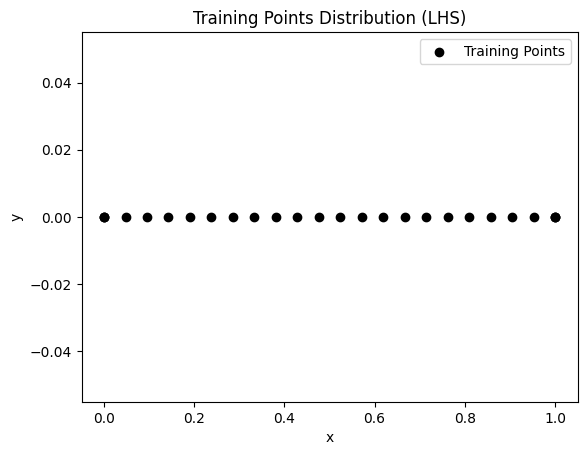

In [ ]:
# Access the training points
train_x = data_simply.train_x
train_y = data_simply.train_y

# Plot the training points
plt.scatter(train_x, np.zeros_like(train_x), c='black', label='Training Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Points Distribution (LHS)')
plt.legend()
plt.show()


In [ ]:
# Neural network architecture
layer_size = [1] + [30] * 5 + [1]  # 1 input layer, 5 hidden layers with 30 neurons each, 1 output layer
activation = "tanh"  # Activation function
initializer = "Glorot uniform"  # Weight initializer
net = dde.maps.FNN(layer_size, activation, initializer)  # Feedforward neural network


In [ ]:
# Create the model for simply
model_simply = dde.Model(data_simply, net)
model_simply.compile("adam", lr=0.0005, metrics=["l2 relative error"])  # Compile the model with Adam optimizer



Compiling model...
Building feed-forward neural network...
'build' took 0.095982 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.440248 s



In [ ]:
# Create the model for contilever
model_contilever = dde.Model(data_contilever, net)
model_contilever.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
'compile' took 4.264499 s



In [ ]:
# Create the model for fixed
model_fixed = dde.Model(data_fixed, net)
model_fixed.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
'compile' took 3.714300 s



In [ ]:
# Train the model for simply
losshistory_s, train_state_s = model_simply.train(epochs=10000, display_every=1000)  # Train for 10000 epochs

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [3.19e+00, 0.00e+00, 0.00e+00, 4.82e-03, 6.42e-03]    [2.90e+00, 0.00e+00, 0.00e+00, 4.82e-03, 6.42e-03]    [3.39e+00]    
1000      [1.38e-03, 6.05e-05, 2.32e-04, 5.61e-05, 1.43e-03]    [8.67e-04, 6.05e-05, 2.32e-04, 5.61e-05, 1.43e-03]    [4.09e-01]    
2000      [7.15e-04, 8.04e-07, 1.28e-05, 1.97e-07, 4.44e-05]    [4.73e-04, 8.04e-07, 1.28e-05, 1.97e-07, 4.44e-05]    [7.57e-02]    
3000      [2.51e-03, 1.78e-06, 1.58e-05, 3.69e-05, 3.40e-05]    [2.35e-03, 1.78e-06, 1.58e-05, 3.69e-05, 3.40e-05]    [4.13e-01]    
4000      [2.66e-04, 1.72e-08, 4.11e-07, 2.17e-08, 2.14e-06]    [1.90e-04, 1.72e-08, 4.11e-07, 2.17e-08, 2.14e-06]    [7.36e-03]    
5000      [4.51e-04, 2.77e-08, 3.04e-07, 8.82e-06, 2.63e-07]    [3.05e-04, 2.77e-08, 3.04e-07, 8.82e-06, 2.63e-07]    [1.72e-01]    
6000      [1.57e-04, 4.61e-09, 9.10e-08, 5.40e-09,

In [ ]:
# Train the model for contilever
losshistory_c, train_state_c = model_contilever.train(epochs=30000, display_every=1000)  # Train for 30000 epochs

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [3.98e-01, 0.00e+00, 1.85e-03, 6.96e-05, 3.17e-04]    [3.15e-01, 0.00e+00, 1.85e-03, 6.96e-05, 3.17e-04]    [1.54e+00]    
1000      [7.61e-04, 8.07e-05, 4.71e-04, 2.81e-04, 2.32e-04]    [7.23e-04, 8.07e-05, 4.71e-04, 2.81e-04, 2.32e-04]    [1.37e-01]    
2000      [3.76e-05, 6.94e-06, 1.32e-06, 8.68e-08, 2.27e-06]    [3.24e-05, 6.94e-06, 1.32e-06, 8.68e-08, 2.27e-06]    [4.58e-02]    
3000      [1.18e-04, 5.99e-05, 1.37e-04, 6.98e-05, 7.47e-05]    [1.20e-04, 5.99e-05, 1.37e-04, 6.98e-05, 7.47e-05]    [8.26e-02]    
4000      [6.99e-06, 9.53e-10, 8.50e-13, 6.62e-09, 6.44e-11]    [6.19e-06, 9.53e-10, 8.50e-13, 6.62e-09, 6.44e-11]    [5.10e-04]    
5000      [4.56e-06, 1.14e-10, 3.35e-09, 4.33e-10, 7.96e-10]    [3.69e-06, 1.14e-10, 3.35e-09, 4.33e-10, 7.96e-10]    [2.11e-04]    
6000      [3.15e-06, 1.34e-11, 1.29e-10, 1.52e-09,

In [ ]:
# Train the model for fixed
losshistory_f, train_state_f = model_fixed.train(epochs=40000, display_every=1000) #Train for 40000 epochs

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.23e-01, 0.00e+00, 2.66e-01, 1.63e-01, 5.98e-02]    [4.03e-01, 0.00e+00, 2.66e-01, 1.63e-01, 5.98e-02]    [1.56e+02]    
1000      [1.53e-04, 4.14e-04, 7.91e-05, 4.19e-04, 1.27e-04]    [9.41e-05, 4.14e-04, 7.91e-05, 4.19e-04, 1.27e-04]    [9.20e+00]    
2000      [2.68e-04, 4.04e-04, 1.77e-04, 3.23e-04, 9.66e-05]    [1.91e-04, 4.04e-04, 1.77e-04, 3.23e-04, 9.66e-05]    [8.69e+00]    
3000      [9.74e-05, 3.52e-04, 7.07e-05, 3.52e-04, 1.18e-04]    [6.17e-05, 3.52e-04, 7.07e-05, 3.52e-04, 1.18e-04]    [8.46e+00]    
4000      [1.08e-04, 3.06e-04, 6.46e-05, 3.16e-04, 9.27e-05]    [6.32e-05, 3.06e-04, 6.46e-05, 3.16e-04, 9.27e-05]    [7.94e+00]    
5000      [8.25e-05, 2.06e-04, 4.17e-05, 2.06e-04, 6.86e-05]    [5.73e-05, 2.06e-04, 4.17e-05, 2.06e-04, 6.86e-05]    [6.47e+00]    
6000      [7.34e-05, 1.16e-04, 2.38e-05, 1.16e-04,

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


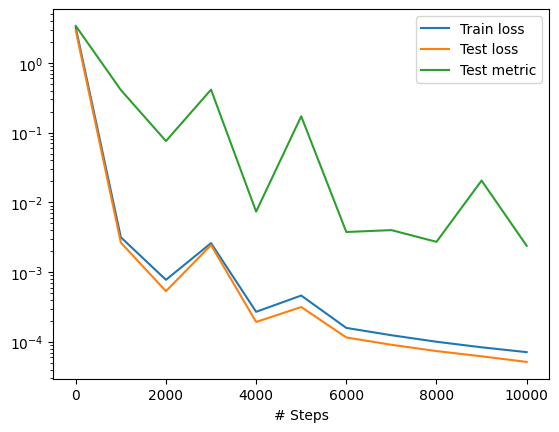

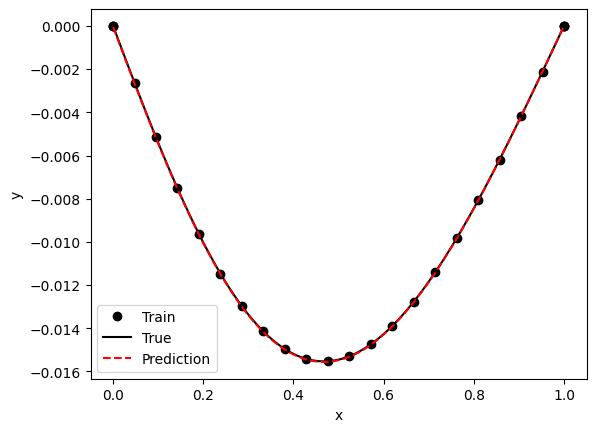

In [ ]:
# Save and plot the results of simply
dde.saveplot(losshistory_s, train_state_s, issave=True, isplot=True)

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


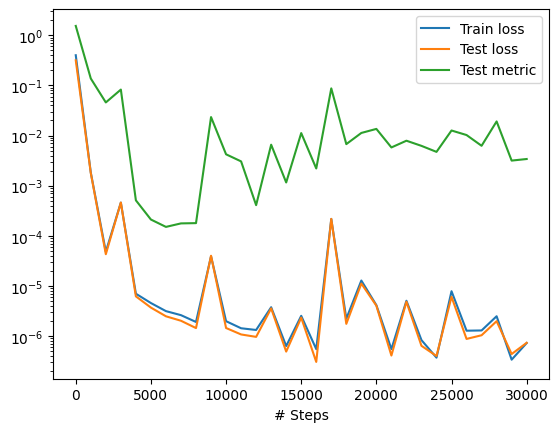

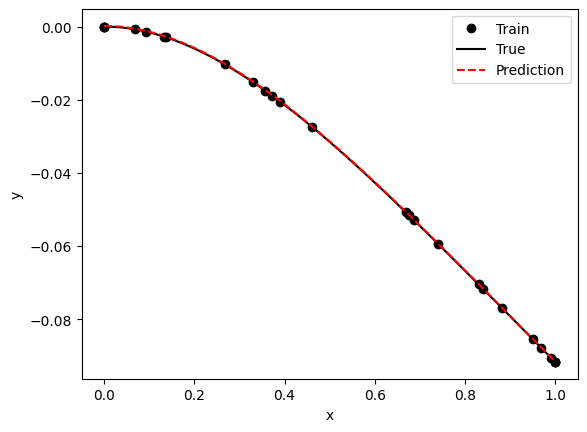

In [ ]:
# Save and plot the results of contilever
dde.saveplot(losshistory_c, train_state_c, issave=True, isplot=True)


Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


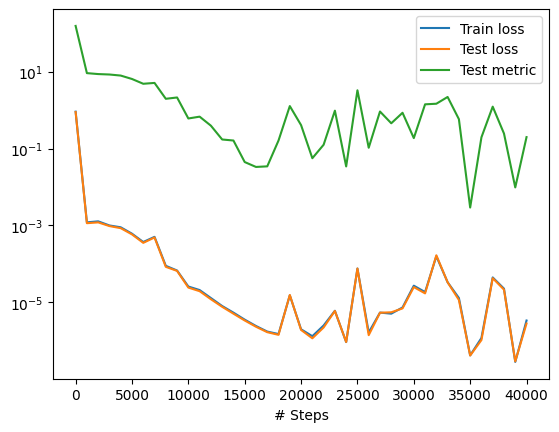

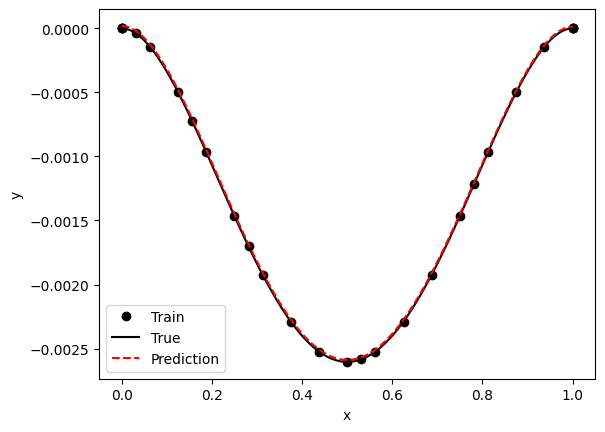

In [ ]:
# Save and plot the results of fixed
dde.saveplot(losshistory_f, train_state_f, issave=True, isplot=True)

#FINITE DIFFERENCE

291 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


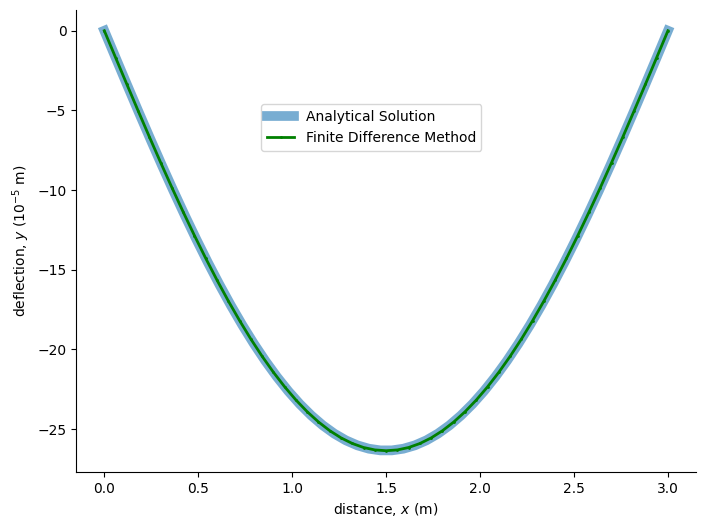

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Solution exact
def y(x):
    """
    Vertical deflection, y, of the beam in 10E-5 m for a simply supported beam under uniform load.

    Args:
    x = position along the beam, m

    Returns:
    y = vertical deflection at position x, scaled by 10E-5 m
    """
    E = 200e9  # Pa
    I = 30000 / 100**4  # m^4
    w = 15 * 1000  # N/m
    L = 3  # m

    # Calculate deflection using beam theory formula for a uniform load
    deflection = -((w * x * (L**3 - 2 * L * x**2 + x**3)) / (24 * E * I)) * 10**5

    return deflection


#fini
def cdiff_beam(L, ya, yb, n):
    """
    Approximate vertical deflection, y, of the beam in 10E-5 m,
    using the central difference method.

    Args:
    L: Length of the beam, m
    ya: Vertical deflection at x = 0
    yb: Vertical deflection at x = L
    n: Desired number of interior segments

    Returns:
    X: Array of x coordinates
    Y: Array of y (deflection) values
    """
    E = 200 * 10**9  # Pa
    I = 30000 / 100**4  # m^4
    w = 15 * 1000  # N/m
    dx = L / n

    X = np.linspace(0, L, n+1)
    A = np.zeros((n+1, n+1))
    b = np.zeros(n+1)

    for i in range(1, n):
        x = X[i]
        b[i] = dx**2 * (1 / (2 * E * I)) * (w * L * x - w * x**2)
        A[i, i-1] = 1
        A[i, i] = -2
        A[i, i+1] = 1

    A[0, 0] = 1
    A[n, n] = 1
    b[0] = ya
    b[n] = yb

    Y = np.linalg.solve(A, b)

    return X, Y




x = np.linspace(0,3)
%timeit X,Y = cdiff_beam(3,0,0,50)

plt.figure(figsize=(8, 6))

plt.plot(x,y(x), lw=7, alpha=0.6, label="Analytical Solution")
plt.plot(X,Y*10**5, "o-", lw=2, ms=1, color="green", label="Finite Difference Method")
plt.legend(bbox_to_anchor=[0.665, 0.81])
plt.xlabel("distance, $x$ (m)")
plt.ylabel("deflection, $y$ (10$^{-5}$ m)")
sns.despine()
plt.show()